<a href="https://colab.research.google.com/github/xbadiam/Marketing_Campaign/blob/main/notebooks/MarketingCampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Campaña de marketing
Aumentar las ganancias de una campaña de marketing

### Contexto

Un modelo de respuesta puede aumentar significativamente la eficiencia de una campaña de marketing, ya sea incrementando las respuestas o reduciendo los gastos. El objetivo es predecir quién responderá a una oferta de un producto o servicio.

In [1]:
!rm -rf /content/Marketing_Campaign

! git clone https://github.com/xbadiam/Marketing_Campaign.git

Cloning into 'Marketing_Campaign'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 74 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 2.31 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import plotly.express as px

# Modelado
# ==============================================================================
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


In [3]:
data = pd.read_csv('/content/Marketing_Campaign/outputs/output.csv')
data.head(10)

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,0,1,68,1617,0,Single,0
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,0,71,27,1,Single,2
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,0,60,776,0,Partner,0
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,0,41,53,1,Partner,1
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,0,44,422,1,Partner,1
5,Postgraduate,Together,62513.0,Without_Kid,With_Teen,2013-09-09,16,520,42,98,...,0,0,0,0,0,58,716,1,Partner,1
6,Graduate,Divorced,55635.0,Without_Kid,With_Teen,2012-11-13,34,235,65,164,...,0,0,0,0,0,54,590,1,Single,1
7,Postgraduate,Married,33454.0,With_Kid,Without_Teen,2013-05-08,32,76,10,56,...,0,0,0,0,0,40,169,1,Partner,1
8,Postgraduate,Together,30351.0,With_Kid,Without_Teen,2013-06-06,19,14,0,24,...,0,0,0,0,1,51,46,1,Partner,1
9,Postgraduate,Together,5648.0,With_Kid,With_Teen,2014-03-13,68,28,0,6,...,0,0,0,0,0,75,49,1,Partner,2


## Preprocesado

In [12]:
#Selección de columnas
data_modify = data.copy()

numeric_cols = data_modify.select_dtypes(include=['number']).columns.tolist()
cat_cols = data_modify.select_dtypes(include=['object', 'category']).columns.tolist()

In [13]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'  # evita incluir columnas no transformadas
)

In [14]:
#Pipeline PCA + KMeans (usando 22 componentes)
pca_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=22, random_state=42)),
])

pca_model = pca_pipeline.fit_transform(data_modify)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.2924 0.083  0.0684 0.0506 0.0388 0.0366 0.0357 0.0335 0.0301 0.0283
 0.0271 0.0243 0.022  0.0215 0.0207 0.0174 0.0164 0.0158 0.0142 0.0133
 0.0123 0.0108]


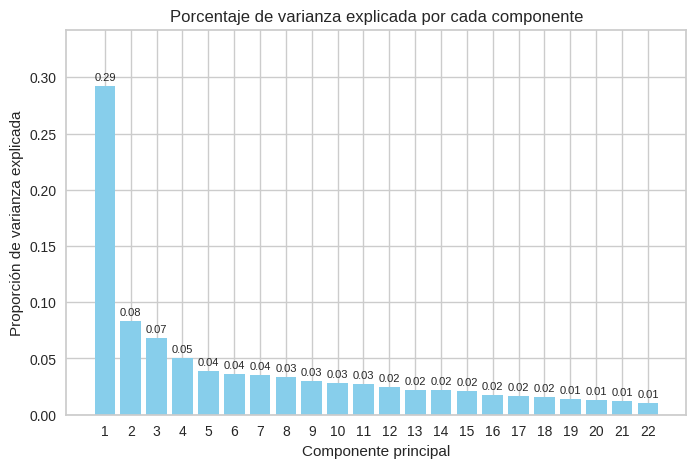

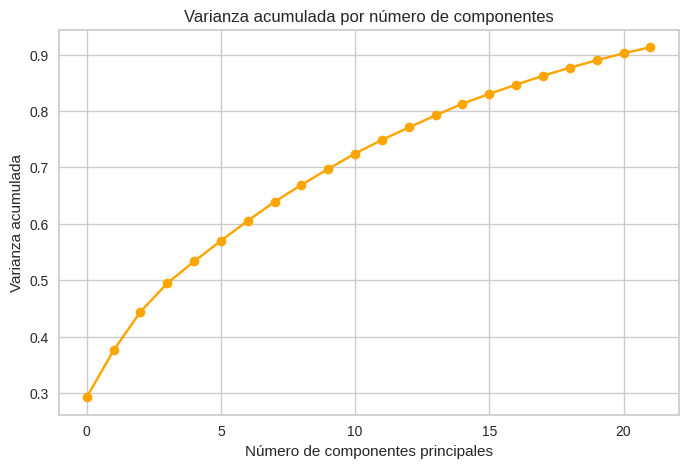

In [15]:
# Obtenemos el objeto PCA del pipeline
pca_model = pca_pipeline.named_steps['pca']

# ----------------------------------------------------
# Porcentaje de varianza explicada por cada componente
# ----------------------------------------------------
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(np.round(pca_model.explained_variance_ratio_, 4))  # 4 decimales para claridad

# Gráfico de la varianza explicada
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x=np.arange(pca_model.n_components_) + 1,
    height=pca_model.explained_variance_ratio_,
    color='skyblue'
)

# Etiquetas de porcentaje sobre las barras
for i, v in enumerate(pca_model.explained_variance_ratio_):
    ax.text(i + 1, v + 0.005, f"{v:.2f}", ha='center', fontsize=8)

ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_ylim(0, max(pca_model.explained_variance_ratio_) + 0.05)
ax.set_title('Porcentaje de varianza explicada por cada componente', fontsize=12)
ax.set_xlabel('Componente principal')
ax.set_ylabel('Proporción de varianza explicada')
plt.show()

# Gráfico acumulativo (opcional y muy útil)
plt.figure(figsize=(8, 5))
plt.plot(
    np.cumsum(pca_model.explained_variance_ratio_), marker='o', color='orange'
)
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()